In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [41]:
water_level_url = "GLHYD_data_metric.csv"
evaporation_url = "evaporation-ont.csv"
precipitation_url = "prc_ont_lake_mon.csv"
runoff_url = "runoff-ont.csv"


water_level_df = pd.read_csv(water_level_url)
evaporation_df = pd.read_csv(evaporation_url)
precipitation_df = pd.read_csv(precipitation_url)
runoff_df = pd.read_csv(runoff_url)


## Water Level Preprocessing

In [42]:


water_level_df = water_level_df.iloc[11:, :] # Remove notes from dataframe
water_level_df.columns = water_level_df.iloc[0,:] # rename columns
water_level_df = water_level_df.reset_index().drop(columns = "index") # reset index
water_level_df.columns.name = "" # Rename index column
water_level_df = water_level_df.iloc[1:, :] # Ensure "year" col is numeric
water_level_df["year"] = water_level_df["year"].astype(int) # convert "year" col to integers
water_level_df = water_level_df[water_level_df['year'] >= 1950].reset_index().drop(columns= "index") #subset data so it starts at 1940
water_level_df['month'] = water_level_df['month'].map({'jan' : 1,
                                                        'feb' : 2,
                                                        'mar' : 3,
                                                        'apr' : 4,
                                                        'may' : 5,
                                                        'jun' : 6,
                                                        'jul' : 7,
                                                        'aug' : 8,
                                                        'sep' : 9,
                                                        'oct' : 10,
                                                        'nov' : 11,
                                                        'dec' : 12
                                                        }) # Rename months to corresponding integers
water_level_df = pd.melt(frame = water_level_df,
                         id_vars= ["month", "year"],
                         value_vars= ["Superior", "Michigan-Huron", "St. Clair", "Erie", "Ontario"],
                         var_name= "lake",
                         value_name= "water level"
                         ) # Make each lake a value in new column "lake"
water_level_df = water_level_df[water_level_df['year'] <= 2020].reset_index().drop(columns= "index")
water_level_df.shape


(4260, 4)

## Evaporation Preprocessing

In [43]:
evaporation_df = pd.melt(frame = evaporation_df,
                         id_vars= "YYYY",
                         value_vars= evaporation_df.columns[1:],
                         var_name= "month",
                         value_name= "evaporation") # Make Months a value in the DF

evaporation_df = evaporation_df.rename(columns= {"YYYY" : "year"}) # Change name of year column

# Since we are assuming that evaporation is constant for all the lakes, we are going to extend this DF so that each lake as the same evaporation.

evaporation_df = pd.concat([evaporation_df] * 5, ignore_index= True)

evaporation_df.head()



,year,month,evaporation
0,1950,Jan,101.10
1,1951,Jan,89.08
2,1952,Jan,82.57
3,1953,Jan,89.67
4,1954,Jan,125.15


## Runoff Preprocessing

In [44]:
runoff_df = runoff_df[runoff_df["Year"] >= 1950]
runoff_df = runoff_df.reset_index().drop(columns = ["index", runoff_df.columns[5]])
runoff_df = pd.concat([runoff_df] * 5, ignore_index= True)
runoff_df

,Year,Mon,Flow,%gauged,#gauges
0,1950,1,1612.18,45.90,10.00
1,1950,2,951.42,45.90,10.00
2,1950,3,2100.59,45.90,10.00
3,1950,4,3057.59,45.90,10.00
4,1950,5,868.02,45.90,10.00
...,...,...,...,...,...
4255,2020,8,270.27,42.64,11.00
4256,2020,9,-999.99,-999.99,-999.99
4257,2020,10,-999.99,-999.99,-999.99
4258,2020,11,-999.99,-999.99,-999.99


## Precipitation Preprocessing

In [45]:
precipitation_df = pd.melt(frame = precipitation_df,
                           id_vars= "YYYY",
                           value_vars= precipitation_df.columns[1:],
                           var_name= "month",
                           value_name= "precipitation") # Turn Month into col values
precipitation_df = precipitation_df.rename(columns= {"YYYY" : "year"}) # rename year column
precipitation_df = precipitation_df[(precipitation_df["year"] >= 1950) & (precipitation_df["year"] <= 2020)] #subset df for 1950 - 2020
precipitation_df = precipitation_df.reset_index().drop(columns = "index")
precipitation_df = pd.concat([precipitation_df] * 5, ignore_index= True)
precipitation_df.shape



(4260, 3)

# New DataFrame

Water level, evaporation, runoff, precipiation

In [46]:
df = pd.concat([water_level_df, evaporation_df, runoff_df, precipitation_df], axis = 1)
df = df.loc[:, ~df.columns.duplicated()]
df = df.drop(columns= "Mon").reset_index().drop(columns = ["index", "Year"])
df = df.rename(columns= {df.columns[5] : "flow"})
print(df.head())
print(df.columns.to_list())
print((df['lake']).unique())

# Clean column names by removing leading/trailing spaces
df.columns = df.columns.str.strip()

# Now you can safely drop the columns
df = df.drop(columns=['%gauged', '#gauges'], inplace=False)

# Print the updated DataFrame
# print(df)
# print(df.columns)

df["precipitation"] = pd.to_numeric(df["precipitation"], errors="coerce")
df["evaporation"] = pd.to_numeric(df["evaporation"], errors="coerce")
df["flow"] = pd.to_numeric(df["flow"], errors="coerce")
df["water level"] = pd.to_numeric(df["water level"], errors="coerce")


# print(df.dtypes)

df_temp = df[df["lake"] == "Ontario"]

print(df_temp)


df.head()

   month  year      lake water level  evaporation     flow   %gauged  \
0      1  1950  Superior      183.42       101.10  1612.18      45.9   
1      2  1950  Superior      183.37        89.08   951.42      45.9   
2      3  1950  Superior      183.33        82.57  2100.59      45.9   
3      4  1950  Superior      183.37        89.67  3057.59      45.9   
4      5  1950  Superior      183.57       125.15   868.02      45.9   

    #gauges precipitation  
0      10.0        106.56  
1      10.0         68.37  
2      10.0          66.2  
3      10.0         62.78  
4      10.0         59.98  
['month', 'year', 'lake', 'water level', 'evaporation', 'flow', ' %gauged', ' #gauges', 'precipitation']
['Superior' 'Michigan-Huron' 'St. Clair' 'Erie' 'Ontario']
      month  year     lake  water level  evaporation     flow  precipitation
3408      1  1950  Ontario        74.52       101.10  1612.18         106.56
3409      2  1950  Ontario        74.68        89.08   951.42          68.37
3410

,month,year,lake,water level,evaporation,flow,precipitation
0,1,1950,Superior,183.42,101.10,1612.18,106.56
1,2,1950,Superior,183.37,89.08,951.42,68.37
2,3,1950,Superior,183.33,82.57,2100.59,66.20
3,4,1950,Superior,183.37,89.67,3057.59,62.78
4,5,1950,Superior,183.57,125.15,868.02,59.98


In [47]:
df

,month,year,lake,water level,evaporation,flow,precipitation
0,1,1950,Superior,183.42,101.10,1612.18,106.56
1,2,1950,Superior,183.37,89.08,951.42,68.37
2,3,1950,Superior,183.33,82.57,2100.59,66.20
3,4,1950,Superior,183.37,89.67,3057.59,62.78
4,5,1950,Superior,183.57,125.15,868.02,59.98
...,...,...,...,...,...,...,...
4255,8,2020,Ontario,75.05,119.69,270.27,84.40
4256,9,2020,Ontario,74.85,128.17,-999.99,84.43
4257,10,2020,Ontario,74.70,74.25,-999.99,77.31
4258,11,2020,Ontario,74.60,90.07,-999.99,98.83


In [48]:
# Filter the DataFrame for each lake
lakes = df["lake"].unique()

lake_dfs = {lake: df[df["lake"] == lake].reset_index(drop=True) for lake in lakes}

# Example: Access the DataFrame for Lake Superior
lake_superior_df = lake_dfs["Superior"]
lake_superior_df.dtypes







month              int64
year               int64
lake              object
water level      float64
evaporation      float64
flow             float64
precipitation    float64
dtype: object

In [49]:
lake_superior_df['water level']

0      183.42
1      183.37
2      183.33
3      183.37
4      183.57
        ...  
847    183.81
848    183.79
849    183.76
850    183.71
851    183.63
Name: water level, Length: 852, dtype: float64

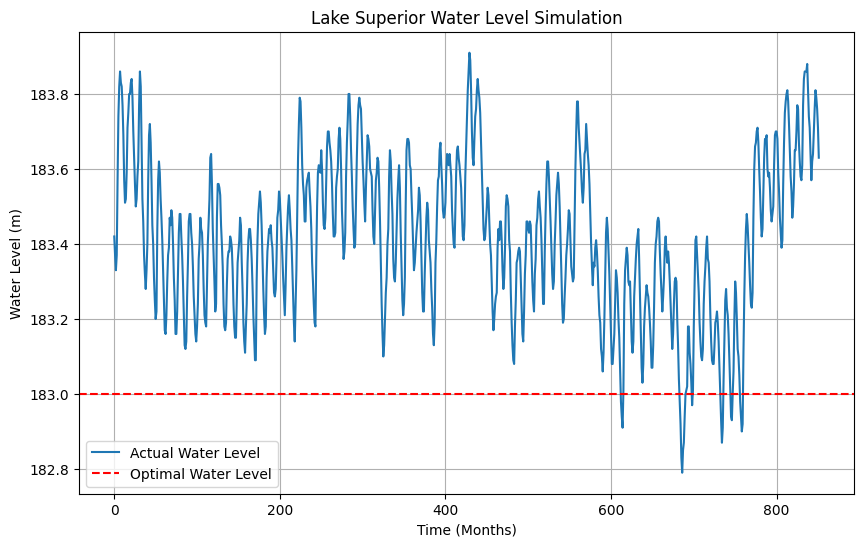

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lake_superior_df['water level'], label = 'Actual Water Level')
plt.axhline(y=183, color='red', linestyle='--', label='Optimal Water Level')
plt.title("Lake Superior Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()

Initial water level: 183.42


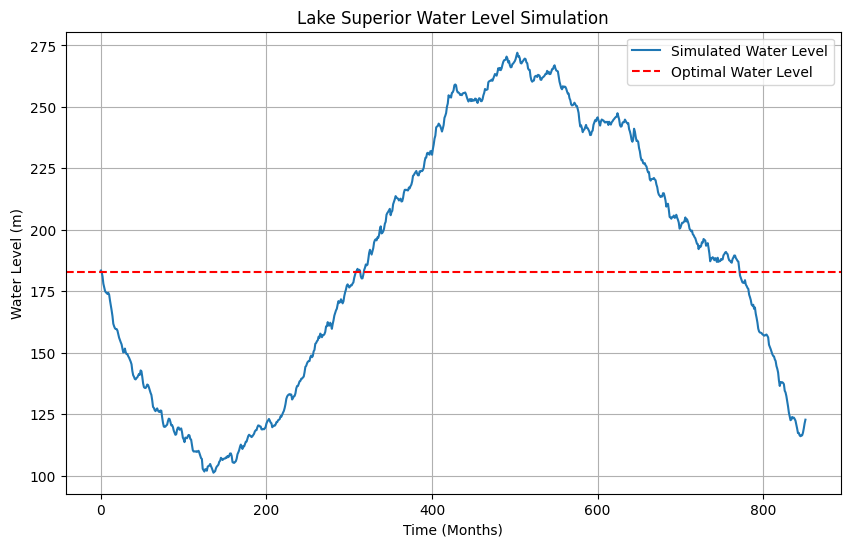

In [51]:
import matplotlib.pyplot as plt

# Function to simulate water level for a lake
def simulate_water_level(lake_df, initial_level, alpha, beta, gamma):
    levels = [initial_level]
    for t in range(1, len(lake_df)):
        precipitation = lake_df.loc[t, "precipitation"]
        evaporation = lake_df.loc[t, "evaporation"]
        flow = lake_df.loc[t, "flow"]
        # Compute water level change
        delta_H = (alpha * precipitation) - (beta * evaporation) - (gamma * flow)
        # print(f"t={t}, delta_H={delta_H}, levels[-1]={levels[-1]}")  # Debugging line
        new_level = levels[-1] + delta_H
        levels.append(new_level)
    return levels

# Example: Simulate for Lake Superior
initial_water_level = lake_superior_df["water level"].iloc[0]
print("Initial water level:", initial_water_level)  # Debugging line
lake_superior_df["simulated_water_level"] = simulate_water_level(
    lake_superior_df, initial_water_level, alpha=0.0253, beta=0.0162, gamma=0.0010
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lake_superior_df["simulated_water_level"], label="Simulated Water Level")
plt.axhline(y=183, color='red', linestyle='--', label='Optimal Water Level')
plt.title("Lake Superior Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()


In [52]:
print(lake_superior_df.dtypes)


month                      int64
year                       int64
lake                      object
water level              float64
evaporation              float64
flow                     float64
precipitation            float64
simulated_water_level    float64
dtype: object


In [53]:
lake_ontario_df = lake_dfs["Ontario"]
lake_ontario_df = lake_ontario_df[lake_ontario_df['flow'] > 0]

print(lake_ontario_df)

     month  year     lake  water level  evaporation     flow  precipitation
0        1  1950  Ontario        74.52       101.10  1612.18         106.56
1        2  1950  Ontario        74.68        89.08   951.42          68.37
2        3  1950  Ontario        74.78        82.57  2100.59          66.20
3        4  1950  Ontario        75.10        89.67  3057.59          62.78
4        5  1950  Ontario        75.17       125.15   868.02          59.98
..     ...   ...      ...          ...          ...      ...            ...
843      4  2020  Ontario        75.32        90.71  1395.79         116.23
844      5  2020  Ontario        75.36       109.37  1314.25          83.49
845      6  2020  Ontario        75.29        76.56   420.30          50.43
846      7  2020  Ontario        75.18        52.49   445.82          67.22
847      8  2020  Ontario        75.05       119.69   270.27          84.40

[848 rows x 7 columns]


In [54]:
lake_ontario_df.head()

,month,year,lake,water level,evaporation,flow,precipitation
0,1,1950,Ontario,74.52,101.10,1612.18,106.56
1,2,1950,Ontario,74.68,89.08,951.42,68.37
2,3,1950,Ontario,74.78,82.57,2100.59,66.20
3,4,1950,Ontario,75.10,89.67,3057.59,62.78
4,5,1950,Ontario,75.17,125.15,868.02,59.98


Initial water level: 74.52


/var/folders/69/ysm8yfcn76s_32xvcxfbp8s00000gn/T/ipykernel_55989/24718862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_ontario_df["simulated_water_level"] = simulate_water_level(


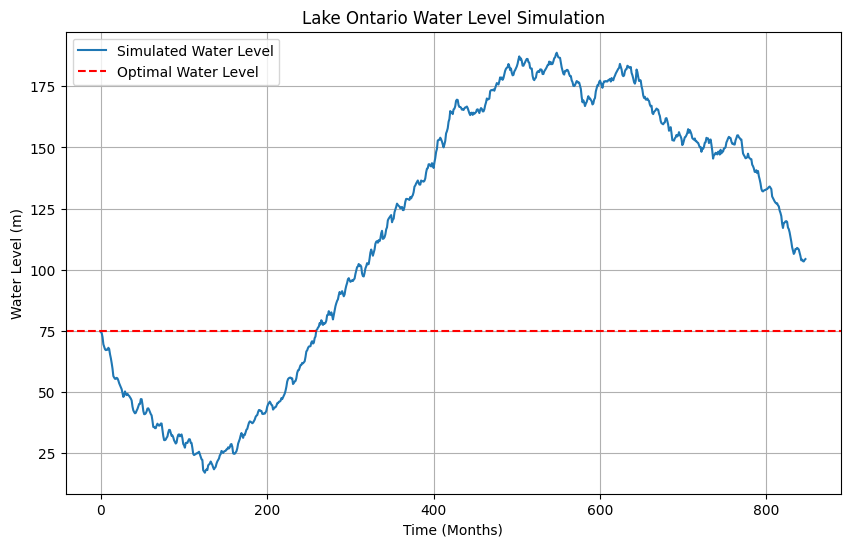

In [55]:
import matplotlib.pyplot as plt

# Function to simulate water level for a lake
def simulate_water_level(lake_df, initial_level, alpha, beta, gamma):
    levels = [initial_level]
    for t in range(1, len(lake_df)):
        precipitation = lake_df.loc[t, "precipitation"]
        evaporation = lake_df.loc[t, "evaporation"]
        flow = lake_df.loc[t, "flow"]
        # Compute water level change
        delta_H = (alpha * precipitation) - (beta * evaporation) - (gamma * flow)
        # print(f"t={t}, delta_H={delta_H}, levels[-1]={levels[-1]}")  # Debugging line
        new_level = levels[-1] + delta_H
        levels.append(new_level)
    return levels

# Example: Simulate for Lake Superior
initial_water_level = lake_ontario_df["water level"].iloc[0]
print("Initial water level:", initial_water_level)  # Debugging line
lake_ontario_df["simulated_water_level"] = simulate_water_level(
    lake_ontario_df, initial_water_level, alpha=0.0256, beta=0.0122, gamma=0.00112
)

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(lake_ontario_df["simulated_water_level"], label="Simulated Water Level")
plt.axhline(y=75, color='red', linestyle='--', label='Optimal Water Level')
plt.title("Lake Ontario Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()


In [56]:
lake_mich_hur_df = df[df['lake'] == 'Michigan-Huron'].reset_index(drop=True)
print(lake_mich_hur_df)

     month  year            lake  water level  evaporation     flow  \
0        1  1950  Michigan-Huron       175.96       101.10  1612.18   
1        2  1950  Michigan-Huron       175.99        89.08   951.42   
2        3  1950  Michigan-Huron       176.02        82.57  2100.59   
3        4  1950  Michigan-Huron       176.17        89.67  3057.59   
4        5  1950  Michigan-Huron       176.27       125.15   868.02   
..     ...   ...             ...          ...          ...      ...   
847      8  2020  Michigan-Huron       177.42       119.69   270.27   
848      9  2020  Michigan-Huron       177.34       128.17  -999.99   
849     10  2020  Michigan-Huron       177.25        74.25  -999.99   
850     11  2020  Michigan-Huron       177.20        90.07  -999.99   
851     12  2020  Michigan-Huron       177.14        98.45  -999.99   

     precipitation  
0           106.56  
1            68.37  
2            66.20  
3            62.78  
4            59.98  
..             ...  


Initial water level: 175.96


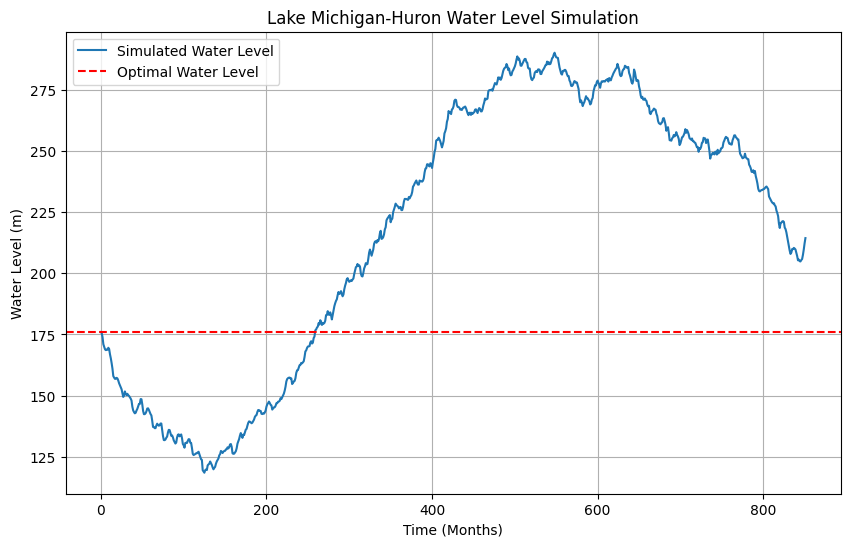

In [57]:
import matplotlib.pyplot as plt

# Function to simulate water level for a lake
def simulate_water_level(lake_df, initial_level, alpha, beta, gamma):
    levels = [initial_level]
    for t in range(1, len(lake_df)):
        precipitation = lake_df.loc[t, "precipitation"]
        evaporation = lake_df.loc[t, "evaporation"]
        flow = lake_df.loc[t, "flow"]
        # Compute water level change
        delta_H = (alpha * precipitation) - (beta * evaporation) - (gamma * flow)
        # print(f"t={t}, delta_H={delta_H}, levels[-1]={levels[-1]}")  # Debugging line
        new_level = levels[-1] + delta_H
        levels.append(new_level)
    return levels

# Example: Simulate for Lake Superior
initial_water_level = lake_mich_hur_df["water level"].iloc[0]
print("Initial water level:", initial_water_level)  # Debugging line
lake_mich_hur_df["simulated_water_level"] = simulate_water_level(
    lake_mich_hur_df, initial_water_level, alpha=0.0256, beta=0.0122, gamma=0.00112
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lake_mich_hur_df["simulated_water_level"], label="Simulated Water Level")
plt.axhline(y=176, color='red', linestyle='--', label='Optimal Water Level')
plt.title("Lake Michigan-Huron Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()


In [58]:
lake_erie_df = df[df['lake'] == 'Erie'].reset_index(drop=True)

print(lake_erie_df)

     month  year  lake  water level  evaporation     flow  precipitation
0        1  1950  Erie       173.90       101.10  1612.18         106.56
1        2  1950  Erie       174.07        89.08   951.42          68.37
2        3  1950  Erie       174.08        82.57  2100.59          66.20
3        4  1950  Erie       174.31        89.67  3057.59          62.78
4        5  1950  Erie       174.36       125.15   868.02          59.98
..     ...   ...   ...          ...          ...      ...            ...
847      8  2020  Erie       174.93       119.69   270.27          84.40
848      9  2020  Erie       174.83       128.17  -999.99          84.43
849     10  2020  Erie       174.72        74.25  -999.99          77.31
850     11  2020  Erie       174.65        90.07  -999.99          98.83
851     12  2020  Erie       174.65        98.45  -999.99          85.05

[852 rows x 7 columns]


In [60]:
lake_ontario_df["water level"]

0      74.52
1      74.68
2      74.78
3      75.10
4      75.17
       ...  
843    75.32
844    75.36
845    75.29
846    75.18
847    75.05
Name: water level, Length: 848, dtype: float64

# Coefficient model

In [67]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load historical data (e.g., 'lake_data.csv')


# Compute change in water level
lake_ontario_df['delta H'] = lake_ontario_df['water level'].diff()



# Drop missing values
lake_ontario_df = lake_ontario_df.dropna()
lake_ontario_df["delta H"]

/var/folders/69/ysm8yfcn76s_32xvcxfbp8s00000gn/T/ipykernel_55989/1880221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_ontario_df['delta H'] = lake_ontario_df['water level'].diff()


,month,year,lake,water level,evaporation,flow,precipitation,simulated_water_level,delta H
1,2,1950,Ontario,74.68,89.08,951.42,68.37,74.117906,0.16
2,3,1950,Ontario,74.78,82.57,2100.59,66.20,72.452611,0.10
3,4,1950,Ontario,75.10,89.67,3057.59,62.78,69.541304,0.32
4,5,1950,Ontario,75.17,125.15,868.02,59.98,68.577780,0.07
5,6,1950,Ontario,75.15,125.32,579.54,42.15,67.478831,-0.02
...,...,...,...,...,...,...,...,...,...
843,4,2020,Ontario,75.32,90.71,1395.79,116.23,104.186888,0.14
844,5,2020,Ontario,75.36,109.37,1314.25,83.49,103.517958,0.04
845,6,2020,Ontario,75.29,76.56,420.30,50.43,103.404198,-0.07
846,7,2020,Ontario,75.18,52.49,445.82,67.22,103.985333,-0.11


In [73]:
from sklearn.preprocessing import StandardScaler
X = lake_ontario_df[['precipitation', 'evaporation', 'flow']]
y = lake_ontario_df['delta H']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X is your feature matrix
# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Extract coefficients
alpha, beta, gamma = model.coef_
print("Alpha (precipitation):", alpha)
print("Beta (evaporation):", beta)
print("Gamma (flow):", gamma)


Alpha (precipitation): -0.00013565859459486473
Beta (evaporation): -0.00021334885724132
Gamma (flow): 0.00013662577990866123


/var/folders/69/ysm8yfcn76s_32xvcxfbp8s00000gn/T/ipykernel_55989/926206393.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_ontario_df["simulated_water_level"] = simulate_water_level(


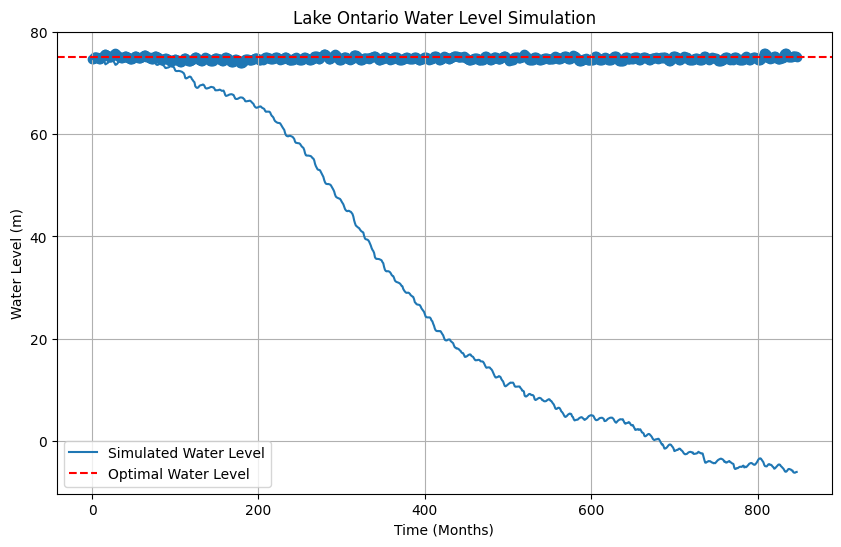

In [99]:
import matplotlib.pyplot as plt

# Function to simulate water level for a lake
def simulate_water_level(lake_df, initial_level, alpha, beta, gamma):
    levels = [initial_level]
    for t in range(1, len(lake_df)):
        precipitation = lake_df.loc[t, "precipitation"]
        evaporation = lake_df.loc[t, "evaporation"]
        flow = lake_df.loc[t, "flow"]
        # Compute water level change
        delta_H = (alpha * precipitation) - (beta * evaporation) - (gamma * flow)
        # print(f"t={t}, delta_H={delta_H}, levels[-1]={levels[-1]}")  # Debugging line
        new_level = levels[-1] + delta_H
        levels.append(new_level)
    return levels

# Example: Simulate for Lake Superior
initial_water_level = lake_ontario_df["water level"].iloc[0]
lake_ontario_df["simulated_water_level"] = simulate_water_level(
    lake_ontario_df, initial_water_level, alpha=0.0003735, beta=-0.0024193, gamma=0.0002366
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(np.linspace(0, len(lake_ontario_df["month"]),len(lake_ontario_df["month"]) ), lake_ontario_df["water level"])
plt.plot(lake_ontario_df["simulated_water_level"], label="Simulated Water Level")
plt.axhline(y=75, color='red', linestyle='--', label='Optimal Water Level')
plt.title("Lake Ontario Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()


/var/folders/69/ysm8yfcn76s_32xvcxfbp8s00000gn/T/ipykernel_55989/197290963.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_ontario_df["simulated_water_level"] = simulate_water_level(


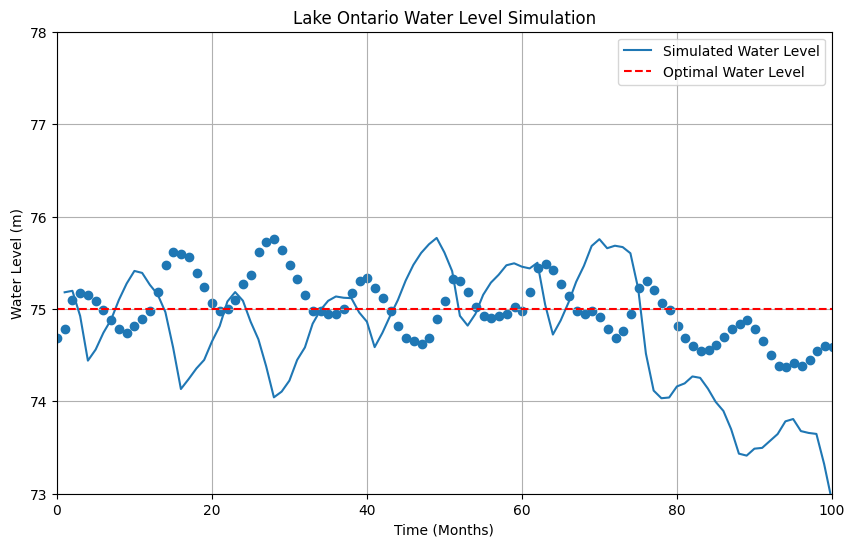

In [105]:
import matplotlib.pyplot as plt

# Function to simulate water level for a lake
def simulate_water_level(lake_df, initial_level, alpha, beta, gamma):
    levels = [initial_level]
    for t in range(1, len(lake_df)):
        precipitation = lake_df.loc[t, "precipitation"]
        evaporation = lake_df.loc[t, "evaporation"]
        flow = lake_df.loc[t, "flow"]
        # Compute water level change
        delta_H = (alpha * precipitation) - (beta * evaporation) - (gamma * flow)
        # print(f"t={t}, delta_H={delta_H}, levels[-1]={levels[-1]}")  # Debugging line
        new_level = levels[-1] + delta_H
        levels.append(new_level)
    return levels

# Example: Simulate for Lake Superior
initial_water_level = lake_ontario_df["water level"].iloc[0]
lake_ontario_df["simulated_water_level"] = simulate_water_level(
    lake_ontario_df, initial_water_level, alpha=0.0003735, beta=-0.0024193, gamma=0.0002366
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(np.linspace(0, len(lake_ontario_df["month"]),len(lake_ontario_df["month"]) ), lake_ontario_df["water level"])
plt.plot(lake_ontario_df["simulated_water_level"] + .5, label="Simulated Water Level")
plt.axhline(y=75, color='red', linestyle='--', label='Optimal Water Level')
plt.xlim(0,100)
plt.ylim(73,78)
plt.title("Lake Ontario Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()
